In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt


In [2]:
from sklearn.calibration import LabelEncoder
from common import get_full_data
def heart_failure():
    df = pd.read_csv("dataset/heart_failure_clinical_records_dataset.csv")
    # get dependent and independent features
    X=df.iloc[:,:-1]
    y=df.iloc[:,-1]
    classes = y.unique()
    X,y=get_full_data(X,y)
    return X,y,[str(c) for c in classes]

def encode_categorical_columns(df):
    le = LabelEncoder()
    # Loop over all columns in the DataFrame
    for col in df.columns:
        # Check if the column is of type object (string)
        if df[col].dtype == 'object':
            # Use LabelEncoder to do the numeric transformation
            df[col] = le.fit_transform(df[col])
    return df

def disease():
    df = pd.read_csv("dataset/disease.csv")
    # get dependent and independent features
    classes = df.iloc[:,0].unique()
    df = encode_categorical_columns(df)

    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    return X,y, classes

In [3]:
from xgboost import XGBRegressor,  XGBClassifier
X,y, y_classes = heart_failure()

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBClassifier(device='cpu')

In [4]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from common import XGB_search_params

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=200,
    cv=5,
    random_state=state,
    n_jobs=-1,
)

search_space_samples=4000

if search_space_samples>=len(X):
    search_space_samples=len(X)-1

_,X_search,_,y_search = train_test_split(X,y,test_size=search_space_samples/len(X))

search.fit(X_search,y_search)
special_model=search.best_estimator_

In [5]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from common import cross_val_classification_report

special_model.device='cpu'
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X.to_numpy(),
    y=y,
    cv=cv,
    target_names=y_classes
)
print(report)

              precision    recall  f1-score   support

           1       0.86      0.92      0.89       609
           0       0.80      0.67      0.73       288

    accuracy                           0.84       897
   macro avg       0.83      0.80      0.81       897
weighted avg       0.84      0.84      0.84       897



computing cross_val_scores...
evaluate score  0.11212772106101121


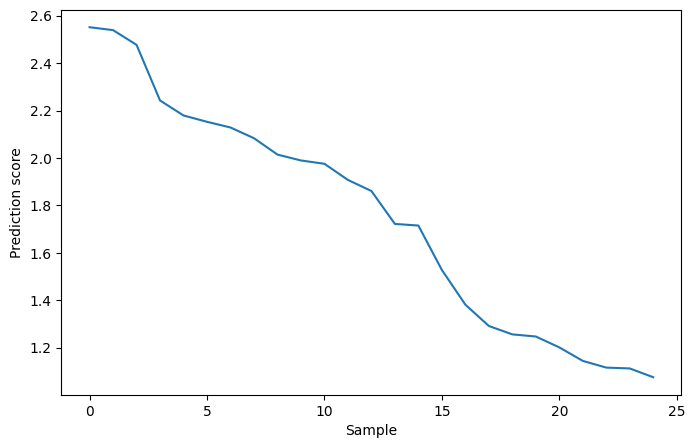

computing cross_val_scores...
evaluate score  0.07909022098172286


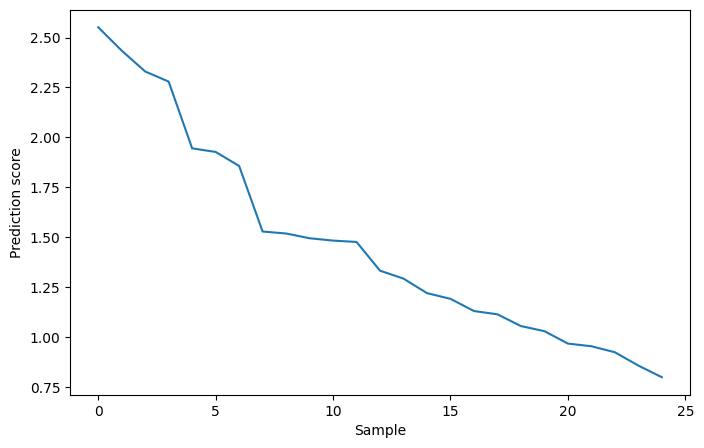

computing cross_val_scores...
evaluate score  0.07839629860230883


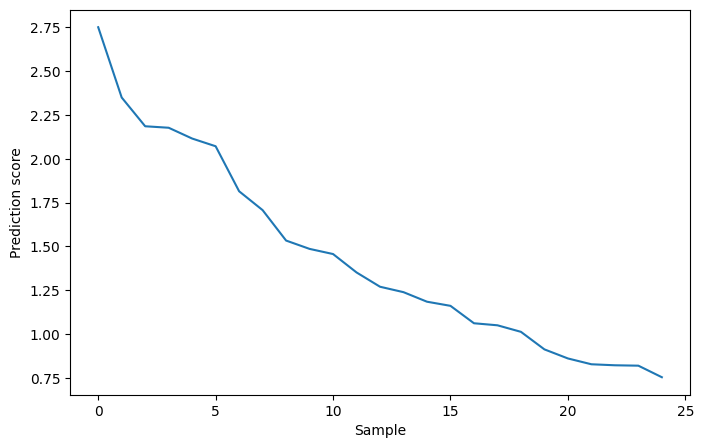

computing cross_val_scores...
evaluate score  0.07827658286699807


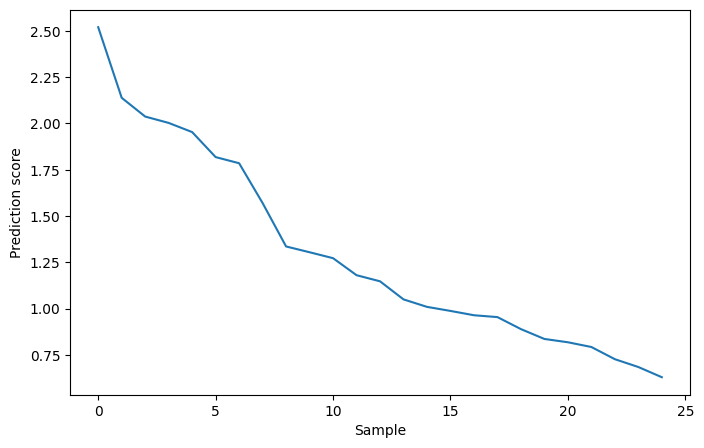

computing cross_val_scores...
evaluate score  0.07184178131305081


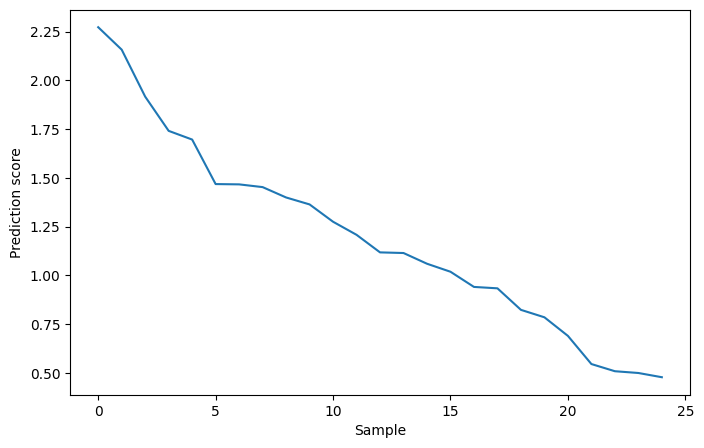

total removed  66
              precision    recall  f1-score   support

           1       0.93      0.96      0.94       495
           0       0.91      0.84      0.87       231

    accuracy                           0.92       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.92      0.92       726



In [6]:
# New method
from common import find_outliers, negate

outliers, score = find_outliers(
    X.to_numpy(),
    y,
    special_model,
    outlier_remove_partition=0.05,
    evaluate_loss=metrics.mean_squared_error,
    pred_loss=metrics.mean_squared_error,
    repeats=5,
    cv=10,
    plot=True
)

X_clean = np.array([x for i,x in enumerate(X.to_numpy()) if i not in outliers])
y_clean = np.array([y_ for i,y_ in enumerate(y) if i not in outliers])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X_clean,
    y=y_clean,
    cv=cv,
    target_names=y_classes
)
print(report)